### - 이미지 처리 : 유클리드 거리/코사인 유사도

- 음식점, 카페의 경우 특징을 추출하기 어려운 부분이 있어 **`관광명소`** 만 사용
- 특성 벡터 추출 후 유클리드 거리/코사인 유사도를 이용해 비교

#### 1. 데이터 읽기

In [ ]:
import pandas as pd

jeju_poi = pd.read_excel('./data/220124/_종합_POI_content.xlsx', index_col=False)
# 인덱스를 초기화하여 유사도 매트릭스와 같은 인덱스를 가지도록 처리
tourism_poi = jeju_poi.query('category_group_name == "관광명소"').reset_index(drop=True)

In [ ]:
tourism_poi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489 entries, 0 to 488
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   idx                  489 non-null    int64  
 1   keyword              489 non-null    object 
 2   address_name         489 non-null    object 
 3   category_group_name  489 non-null    object 
 4   category_name        489 non-null    object 
 5   id                   489 non-null    int64  
 6   place_name           489 non-null    object 
 7   x                    489 non-null    float64
 8   y                    489 non-null    float64
 9   rating               489 non-null    float64
 10  kind                 489 non-null    object 
dtypes: float64(3), int64(2), object(6)
memory usage: 42.1+ KB


In [ ]:
tourism_poi.head(1)

,idx,keyword,address_name,category_group_name,category_name,id,place_name,x,y,rating,kind
0,0,테마파크,제주특별자치도 제주시 연동 1320,관광명소,"문화,예술 > 문화시설 > 박물관",26388484,수목원테마파크 아이스뮤지엄,126.488398,33.470777,1.0,제주시


#### 2. 특징 추출 클래스

- tensorflow를 사용하여 모델 구현
  - 사전 학습 모델 VGG16 사용


- 특징 추출 클래스 구현

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from pathlib import Path
from PIL import Image

class FeatureExtractor:
    def __init__(self):
        # Use VGG-16 as the architecture and ImageNet for the weight
        self.base_model = VGG16(weights='imagenet')
        # Customize the model to return features from fully-connected layer
        self.model = Model(inputs=self.base_model.input, outputs=self.base_model.get_layer('fc1').output)
    def extract(self, img):
        # Convert the image color space
        img = img.convert('RGB')
        # Reformat the image
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        # Extract Features
        feature = self.model.predict(x)[0]
        return feature / np.linalg.norm(feature)

#### 3. 이미지 특징 벡터 추출

- 특징 벡터 클래스 선언

In [ ]:
fe = FeatureExtractor()

- 이미지에 대한 특징 벡터 추출
  - 각 특징 벡터 저장
  - 전체 특징 벡터 저장
  - 특징 벡터에 대한 이미지 정보 저장

In [ ]:
import numpy as np
from tqdm.notebook import tqdm

img_home = './data/220122/종합_이미지/관광명소/'
features = []
img_paths = []

# Save Image Feature Vector with Database Images
for idx, row in tqdm(tourism_poi.iterrows()):
  try:
    p_name = str(row['id'])+'_'+row['place_name']
    image_path = img_home + p_name + '.png'
    img_paths.append(image_path)

    # Extract Features
    feature = fe.extract(img=Image.open(image_path))

    features.append(feature)

    # Save the Numpy array (.npy) on designated path
    feature_path = "./data/220124/이미지_특징_벡터/관광명소/" + p_name + ".npy"
    np.save(feature_path, feature)

  except Exception as e:
    print('-'*30)
    print(idx, row['id'], row['place_name'])
    print('예외가 발생했습니다.')
    print(e)

0it [00:00, ?it/s]

- 특징 벡터에 대한 이미지 정보 획득
  - 아이디, 장소명, 파일명

In [ ]:
file_names = [path.split('/')[-1] for path in img_paths]
id_list = [file.split('_')[0] for file in file_names]
place_names = [file.split('_')[1][:-4] for file in file_names]

In [ ]:
file_names[:2], id_list[:2], place_names[:2]

(['26388484_수목원테마파크 아이스뮤지엄.png', '1129394481_고스트타운.png'],
 ['26388484', '1129394481'],
 ['수목원테마파크 아이스뮤지엄', '고스트타운'])

- 특징 벡터에 대한 이미지 파일 정보 저장

In [ ]:
# import pandas as pd

# toursim_image_info = pd.DataFrame({
#     'id' : id_list,
#     'place_name' : place_names, 
#     'file' : file_names,
#     'path' : img_paths,
# })

# toursim_image_info.to_excel('./data/220124/_관광명소_이미지_정보.xlsx', index=False)

- 전체 특징 벡터 저장

In [ ]:
# np.save('./data/220124/_image_feature_vector.npy', np.array(features))

In [ ]:
test_npy = np.load('./data/220124/_image_feature_vector.npy')
test_npy.shape, test_npy[0].shape, test_npy[0]

((489, 4096),
 (4096,),
 array([0.01137046, 0.        , 0.        , ..., 0.        , 0.        ,
        0.00867253], dtype=float32))

#### 4. 유사도 추출

##### ◽유클리드 거리

- features를 이용해 각 이미지에 대한 유클리드 거리 측정

In [ ]:
import numpy as np

euclidean_dist = np.zeros((len(features), len(features)))

for idx, f in enumerate(features):
    euclidean_dist[idx] = np.linalg.norm(f - features, axis= 1)

In [ ]:
print(tourism_poi.loc[17, 'place_name'])
np.sort(euclidean_dist[17])[:5], np.argsort(euclidean_dist[17])[:5]

곽지해수욕장


(array([0.        , 0.61169487, 0.69499731, 0.70247924, 0.71290338]),
 array([ 17,  82, 278,  63, 289], dtype=int64))

In [ ]:
# np.save('./data/220124/_image_euclidean_dist.npy', euclidean_dist)

##### ◽코사인 유사도

- features를 이용해 각 이미지에 대한 코사인 유사도 측정

In [ ]:
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = np.zeros((len(features), len(features)))

for idx, f in tqdm(enumerate(features)):
    cosine_sim[idx] = cosine_similarity([f], features)

0it [00:00, ?it/s]

In [ ]:
print(tourism_poi.loc[17, 'place_name'])
np.sort(cosine_sim[17])[-5:], np.argsort(cosine_sim[17])[-5:]

곽지해수욕장


(array([0.74588454, 0.75326157, 0.75848937, 0.81291461, 1.00000012]),
 array([289,  63, 278,  82,  17], dtype=int64))

In [ ]:
# np.save('./data/220124/_image_cosine_sim.npy', cosine_sim)

#### 5. 유사도 추출 테스트

- 유사도 결과가 비슷한 것을 확인할 수 있다.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import set_matplotlib_korean

euclidean_dist = np.load('./data/220124/_image_euclidean_dist.npy')
cosine_sim = np.load('./data/220124/_image_cosine_sim.npy')

img_info = pd.read_excel('./data/220124/_관광명소_이미지_정보.xlsx', index_col=False)

Korean OK in your Windwos !!!


##### ◽유클리드 거리

In [ ]:
img_info['euclidean_dist'] = euclidean_dist[17]

In [ ]:
img_info.sort_values('euclidean_dist', ascending=True)[['id', 'place_name', 'path', 'euclidean_dist']][:5]

,id,place_name,path,euclidean_dist
17,25022153,곽지해수욕장,./data/220122/종합_이미지/관광명소/25022153_곽지해수욕장.png,0.000000
82,13323388,알작지해변,./data/220122/종합_이미지/관광명소/13323388_알작지해변.png,0.611695
278,7964223,세화해변,./data/220122/종합_이미지/관광명소/7964223_세화해변.png,0.694997
63,25069292,제주 종달리전망대,./data/220122/종합_이미지/관광명소/25069292_제주 종달리전망대.png,0.702479
289,8132634,하고수동해변,./data/220122/종합_이미지/관광명소/8132634_하고수동해변.png,0.712903


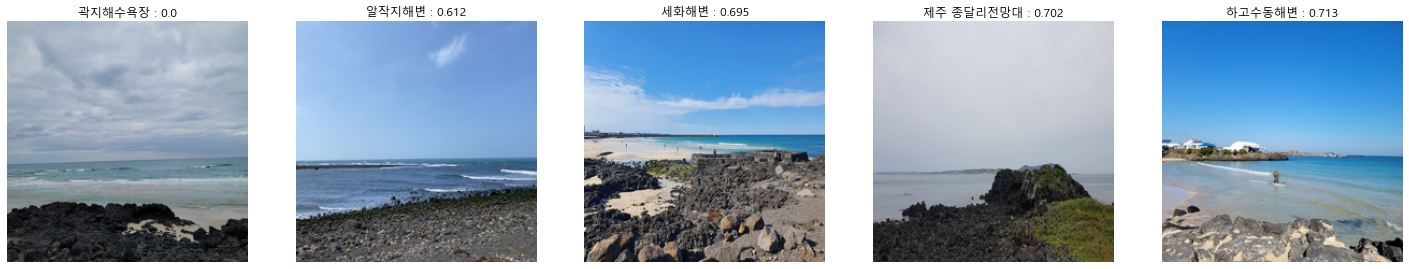

In [ ]:
temp = img_info.sort_values('euclidean_dist', ascending=True)[['id', 'place_name', 'path', 'euclidean_dist']][:5]
plt.figure(figsize=(25, 5))
i = 1
for idx, row in temp.iterrows():
    plt.subplot(1, 5, i)
    img = plt.imread(row['path'])
    plt.imshow(img)
    plt.gca().set_title(row['place_name']+' : '+str(round(row['euclidean_dist'], 3)))
    plt.axis(False)
    i += 1
plt.show()

##### ◽코사인 유사도

In [ ]:
img_info['cosine_sim'] = cosine_sim[17]

In [ ]:
img_info.sort_values('cosine_sim', ascending=False)[['id', 'place_name', 'path', 'cosine_sim']][:5]

,id,place_name,path,cosine_sim
17,25022153,곽지해수욕장,./data/220122/종합_이미지/관광명소/25022153_곽지해수욕장.png,1.000000
82,13323388,알작지해변,./data/220122/종합_이미지/관광명소/13323388_알작지해변.png,0.812915
278,7964223,세화해변,./data/220122/종합_이미지/관광명소/7964223_세화해변.png,0.758489
63,25069292,제주 종달리전망대,./data/220122/종합_이미지/관광명소/25069292_제주 종달리전망대.png,0.753262
289,8132634,하고수동해변,./data/220122/종합_이미지/관광명소/8132634_하고수동해변.png,0.745885


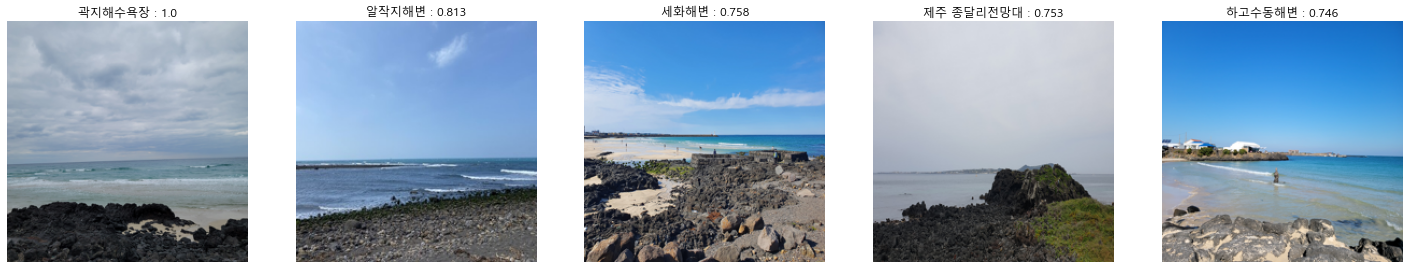

In [ ]:
temp = img_info.sort_values('cosine_sim', ascending=False)[['id', 'place_name', 'path', 'cosine_sim']][:5]
plt.figure(figsize=(25, 5))
i = 1
for idx, row in temp.iterrows():
    plt.subplot(1, 5, i)
    img = plt.imread(row['path'])
    plt.imshow(img)
    plt.gca().set_title(row['place_name']+' : '+str(round(row['cosine_sim'], 3)))
    plt.axis(False)
    i += 1
plt.show()

### - 숙박 시설↔관광지 거리

- 관광지 주변의 숙박 시설을 보여주기 위해 숙박 시설과 관광명소 사이의 거리를 Pandas.Dataframe 형태로 저장

In [ ]:
import pandas as pd

accom_poi = pd.read_excel('./data/220124/_종합_숙박.xlsx', index_col=False)
jeju_poi = pd.read_excel('./data/220123/_종합_POI_content.xlsx', index_col=False)

In [ ]:
accom_poi.head(1)

,id,place_name,address_name,place_url,x,y,keyword,rating,grade
0,907075,월정힐펜션,제주특별자치도 제주시 구좌읍 월정리 699-3,http://place.map.kakao.com/907075,126.791441,33.557925,펜션,5.0,펜션


In [ ]:
jeju_poi.head(1)

,idx,keyword,address_name,category_group_name,category_name,id,place_name,x,y,rating,kind,content
0,0,테마파크,제주특별자치도 제주시 연동 1320,관광명소,"문화,예술 > 문화시설 > 박물관",26388484,수목원테마파크 아이스뮤지엄,126.488398,33.470777,1.0,제주시,테마파크 관광명소


#### 1. 위도, 경도를 이용한 직선거리 함수

- 위도, 경도 계산
    - 우리나라 기준 1도 = 88.8km, 1분 = 1.48km, 1초 = 25m
    - 구글의 좌표는 `도` 기준
    - 위도 차이 : ((a.lat - b.lat) * 88.8) km
    - 경도 차이 : ((a.lng - b.lng) * 88.8) km
    - 거리 차이 : (위도 차이 ** 2 + 경도 차이 ** 2) ** (1/2) km

**미리 계산을 진행해둘 계획이였지만, 계산이 오래 거릴지 않아 함수만 유지**

In [ ]:
# pos1 : (x좌표, y좌표)
# pos2 : (x좌표, y좌표)
def cal_dist(pos1, pos2):
    return (((pos1[1] - pos2[1])*88.8)**2 +((pos1[0] - pos2[0])*88.8)**2)**(1/2)

#### 2. 숙박 시설↔관광지 거리

- **계산이 예상보다 빨라서 필요한 경우 계산하여 사용하는 것으로 결정**

In [ ]:
from tqdm.notebook import tqdm

for idx, row in tqdm(jeju_poi.iterrows()):
    accom_poi[str(row['id'])] = cal_dist((accom_poi['x'], accom_poi['y']), (row['x'], row['y']))

0it [00:00, ?it/s]

C:\Users\ISANGH~1\AppData\Local\Temp/ipykernel_31216/1861455450.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  accom_poi[str(row['id'])] = cal_dist((accom_poi['x'], accom_poi['y']), (row['x'], row['y']))


In [ ]:
accom_poi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3004 entries, 0 to 3003
Columns: 3017 entries, id to 25548687
dtypes: float64(3011), int64(1), object(5)
memory usage: 69.1+ MB


In [ ]:
accom_poi.head(1)

,id,place_name,address_name,place_url,x,y,keyword,rating,grade,26388484,...,1643413816,13723872,27441187,742400088,1218626372,18951459,75702988,1421354324,1620380468,25548687
0,907075,월정힐펜션,제주특별자치도 제주시 구좌읍 월정리 699-3,http://place.map.kakao.com/907075,126.791441,33.557925,펜션,5.0,펜션,28.00091,...,25.889372,27.345294,31.238286,31.180461,31.241943,31.227433,30.986696,31.23961,30.542049,29.131936


### - 주변 관광지 개수

- 5KM(임시) 내의 주변 관광지 개수 : 관광명소, 음식점, 카페

In [ ]:
import pandas as pd

jeju_poi = pd.read_excel('./data/220123/_종합_POI_content.xlsx', index_col=False)

In [ ]:
jeju_poi.head(1)

,idx,keyword,address_name,category_group_name,category_name,id,place_name,x,y,rating,kind,content
0,0,테마파크,제주특별자치도 제주시 연동 1320,관광명소,"문화,예술 > 문화시설 > 박물관",26388484,수목원테마파크 아이스뮤지엄,126.488398,33.470777,1.0,제주시,테마파크 관광명소


#### 1. 주변 광광지 개수 계산 함수

In [ ]:
def adjacent_poi_count(poi1, poi2):
    dist = cal_dist(poi1, poi2)
    return len(dist[dist <= 5])

#### 2. 주변 관광지 개수

- adjacent_tour : 주변 관광명소 수 
- adjacent_rest : 주변 음식점 수
- adjacent_cafe : 주변 카페 수

In [ ]:
from tqdm.notebook import tqdm

jeju_poi['adjacent_tour'] = 0
jeju_poi['adjacent_rest'] = 0
jeju_poi['adjacent_cafe'] = 0
for idx, row in tqdm(jeju_poi.iterrows()):
    temp_tour = jeju_poi.drop(idx, axis=0).query('category_group_name == "관광명소"')
    temp_rest = jeju_poi.drop(idx, axis=0).query('category_group_name == "음식점"')
    temp_cafe = jeju_poi.drop(idx, axis=0).query('category_group_name == "카페"')

    jeju_poi.loc[idx, 'adjacent_tour'] = adjacent_poi_count((row['x'], row['y']), (temp_tour['x'], temp_tour['y']))
    jeju_poi.loc[idx, 'adjacent_rest'] = adjacent_poi_count((row['x'], row['y']), (temp_rest['x'], temp_rest['y']))
    jeju_poi.loc[idx, 'adjacent_cafe'] = adjacent_poi_count((row['x'], row['y']), (temp_cafe['x'], temp_cafe['y']))

    del temp_tour
    del temp_rest
    del temp_cafe

0it [00:00, ?it/s]

In [ ]:
jeju_poi[['adjacent_tour', 'adjacent_rest', 'adjacent_cafe']].head(5)

,adjacent_tour,adjacent_rest,adjacent_cafe
0,29,268,138
1,17,168,45
2,22,43,16
3,19,21,6
4,19,131,56


In [ ]:
# jeju_poi.to_excel('./data/220124/_종합_POI_주변관광지.xlsx', index=False)

#### 3. 데이터 확인

In [ ]:
import pandas as pd

jeju_poi_adjacent = pd.read_excel('./data/220124/_종합_POI_주변관광지.xlsx', index_col=False)

In [ ]:
jeju_poi_adjacent.head(3)

,idx,keyword,address_name,category_group_name,category_name,id,place_name,x,y,rating,kind,content,adjacent_tour,adjacent_rest,adjacent_cafe
0,0,테마파크,제주특별자치도 제주시 연동 1320,관광명소,"문화,예술 > 문화시설 > 박물관",26388484,수목원테마파크 아이스뮤지엄,126.488398,33.470777,1.0,제주시,테마파크 관광명소,29,268,138
1,1,"테마파크,가볼만한 곳",제주특별자치도 제주시 애월읍 신엄리 2880-12,관광명소,"여행 > 관광,명소 > 테마파크",1129394481,고스트타운,126.356936,33.476195,3.4,제주시,테마파크 가볼만한곳 관광명소,17,168,45
2,2,"테마파크,가볼만한 곳",제주특별자치도 제주시 애월읍 유수암리 1083,관광명소,"여행 > 관광,명소 > 테마파크",891104398,제주불빛정원,126.409179,33.422294,4.1,제주시,테마파크 가볼만한곳 관광명소,22,43,16


- 인접 관광지의 통계량 확인

In [ ]:
jeju_poi_adjacent[['adjacent_tour', 'adjacent_rest', 'adjacent_cafe']].describe()

,adjacent_tour,adjacent_rest,adjacent_cafe
count,3008.000000,3008.000000,3008.000000
mean,21.706117,155.068484,64.712101
std,6.499756,109.871119,49.360010
min,0.000000,0.000000,0.000000
25%,18.000000,68.750000,31.000000
50%,21.000000,126.000000,45.500000
75%,27.000000,212.000000,90.000000
max,42.000000,389.000000,179.000000


- 인접 관광지의 히스토그램 확인
  - `adjacent_tour`는 분포가 정규분포에 가깝다.
  - `adjacent_rest`, `adjacent_cafe`는 불균형이 존재한다.

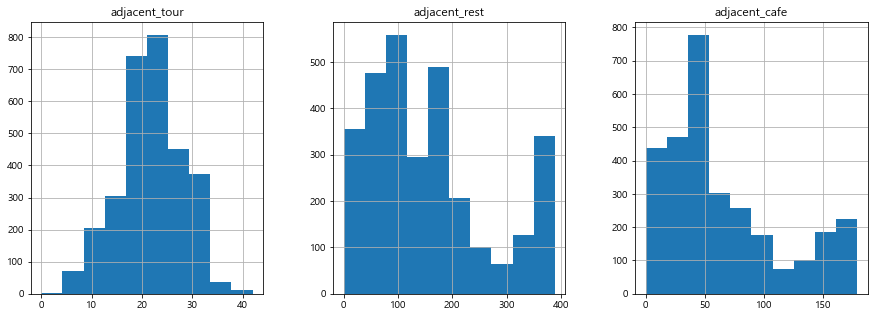

In [ ]:
jeju_poi_adjacent[['adjacent_tour', 'adjacent_rest', 'adjacent_cafe']].hist(layout=(1, 3), figsize=(15, 5));